Mean:  0.008462362
Std:  0.022823164
Min:  -0.1384322
Median:  0.011061709
Max:  0.113603175


Text(0, 0.5, 'Count')

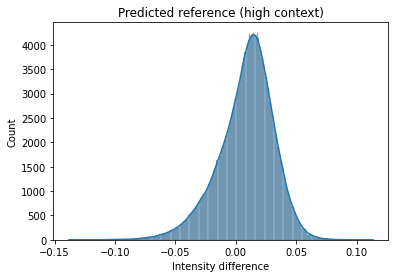

In [19]:
import os 
import matplotlib.pyplot as plt
import numpy as np
from locscale.include.emmer.ndimage.map_utils import load_map, save_as_mrc 
import seaborn as sns

locscale_map_path = "/home/abharadwaj1/dev/dirty_tests/high_context/emd_3061_high_context_locscale_output.mrc"
model_map_path = "/home/abharadwaj1/dev/dirty_tests/high_context/emd_3061_high_context_mean.mrc"
mask_path = "/home/abharadwaj1/papers/elife_paper/figure_information/data/maps/emd_3061/model_based/processing_files/EMD_3061_unfiltered_confidenceMap.mrc"

locscale_map, apix = load_map(locscale_map_path)
model_map, apix = load_map(model_map_path)
mask, _ = load_map(mask_path)
diff_map = locscale_map - model_map
mask_binarize = (mask > 0.5).astype(bool)
diff_map_nonzero = diff_map[mask_binarize]
# plot the histogram of non-zero values
print("Mean: ", np.mean(diff_map_nonzero))
print("Std: ", np.std(diff_map_nonzero))
print("Min: ", np.min(diff_map_nonzero))
print("Median: ", np.median(diff_map_nonzero))
print("Max: ", np.max(diff_map_nonzero))

sns.histplot(diff_map_nonzero, kde=True)
plt.title("Predicted reference (high context)")
plt.xlabel("Intensity difference")
plt.ylabel("Count")

In [20]:
mapdir = os.path.dirname(locscale_map_path)
save_as_mrc(diff_map, os.path.join(mapdir, "diff_map_locscale_modelmap.mrc"), apix=apix)


In [21]:
#model_free_intensity_difference = diff_map_nonzero
#hybrid_intensity_difference = diff_map_nonzero
#model_based_intensity_difference = diff_map_nonzero
predicted_high_context_intensity_difference = diff_map_nonzero

Text(0.5, 1.0, 'Predicted vs Hybrid intensity difference')

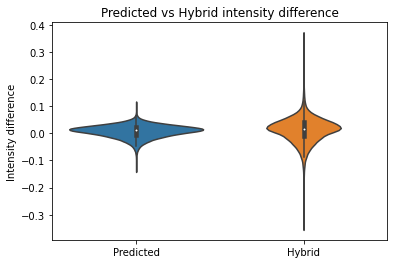

In [24]:
sns.violinplot([predicted_high_context_intensity_difference, hybrid_intensity_difference], inner="box")
plt.xticks([0, 1], ['Predicted', 'Hybrid'])
plt.ylabel("Intensity difference")
plt.title("Predicted vs Hybrid intensity difference")


Text(0.5, 1.0, 'Z-score distribution of the significance test')

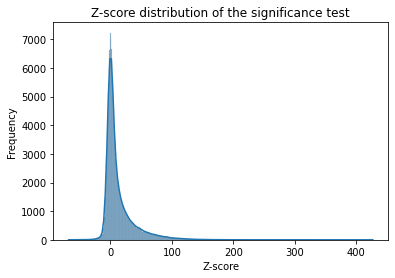

In [25]:
zscore_map_path = "/home/abharadwaj1/dev/dirty_tests/high_context/z_score_map.mrc"
zscore_map, apix = load_map(zscore_map_path)
zscore_masked = zscore_map[mask_binarize]

sns.histplot(zscore_masked, kde=True)
plt.xlabel("Z-score")
plt.ylabel("Frequency")
plt.title("Z-score distribution of the significance test")


Number of negative zscores: 66970
Number of positive zscores: 102643


Text(0.5, 1.0, 'Z-score distribution within tight mask')

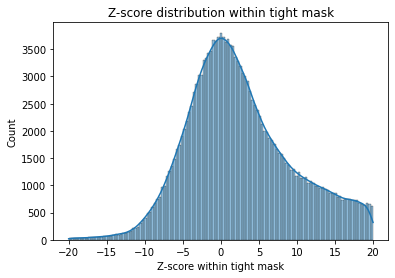

In [49]:
zscore_clip = zscore_masked[(zscore_masked > -20) & (zscore_masked < 20)]
num_negative_zscores_masked = np.sum(zscore_clip < 0)
num_positive_zscores_masked = np.sum(zscore_clip > 0)

print("Number of negative zscores: {}".format(num_negative_zscores_masked))
print("Number of positive zscores: {}".format(num_positive_zscores_masked))

sns.histplot(zscore_clip,  kde=True)
plt.xlabel("Z-score within tight mask")
plt.ylabel("Count")
plt.title("Z-score distribution within tight mask")

In [30]:
from scipy.stats import skew 

skew_z_score = skew(zscore_masked)
skew_intensity_diff_pred = skew(predicted_high_context_intensity_difference)

print("Skew of the z-scored map: ", skew_z_score)
print("Skew of the predicted intensity difference: ", skew_intensity_diff_pred)


Skew of the z-scored map:  2.6863113992569527
Skew of the predicted intensity difference:  -0.6249678383770606


In [28]:
# number of negative z scores and positive z scores
num_negative_z_scores = np.sum(zscore_masked < 0)
num_positive_z_scores = np.sum(zscore_masked > 0)

print("Number of negative z scores: {}".format(num_negative_z_scores))
print("Number of positive z scores: {}".format(num_positive_z_scores))

num_negative_predicted_intensity_diff = np.sum(predicted_high_context_intensity_difference < 0)
num_positive_predicted_intensity_diff = np.sum(predicted_high_context_intensity_difference > 0)

print("Number of negative predicted intensity differences: {}".format(num_negative_predicted_intensity_diff))
print("Number of positive predicted intensity differences: {}".format(num_positive_predicted_intensity_diff))


Number of negative z scores: 67696
Number of positive z scores: 152494
Number of negative predicted intensity differences: 67696
Number of positive predicted intensity differences: 152494


In [39]:
from locscale.include.emmer.pdb.pdb_utils import set_atomic_bfactors
from locscale.include.emmer.pdb.pdb_to_map import pdb2map
import gemmi

pdb_path = "/home/abharadwaj1/papers/elife_paper/figure_information/data/maps/emd_3061/hybrid/sharp_and_blur/5a63_shifted_integrated_pseudoatoms_servalcat_refined.pdb"
st = gemmi.read_structure(pdb_path)
st_0 = set_atomic_bfactors(input_gemmi_st=st, b_iso=0) 
st_999 = set_atomic_bfactors(input_gemmi_st=st, b_iso=999)

map_0bfactor = pdb2map(st_0, size=mask.shape, apix=apix)
map_999bfactor = pdb2map(st_999, size=mask.shape, apix=apix)

pdb_dir = os.path.dirname(pdb_path)

save_as_mrc(map_0bfactor, os.path.join(pdb_dir, "hybrid_0bfactor.mrc"), apix=apix)
save_as_mrc(map_999bfactor, os.path.join(pdb_dir, "hybrid_999bfactor.mrc"), apix=apix)




In [44]:
blurred_map_mask = (map_999bfactor > 0.045).astype(bool)
sharp_map_mask = (map_0bfactor > 0.2).astype(bool)

# interatomic space is the voxels belonging to only blurred map and not sharp map

interatomic_space_mask = blurred_map_mask & (~sharp_map_mask)
print("Number of voxels in interatomic space: ", np.sum(interatomic_space_mask))
print("Number of voxels in atomic space: ", np.sum(sharp_map_mask))

Number of voxels in interatomic space:  109594
Number of voxels in atomic space:  35987


Text(0.5, 1.0, 'Z-score distribution of interatomic space and atomic space')

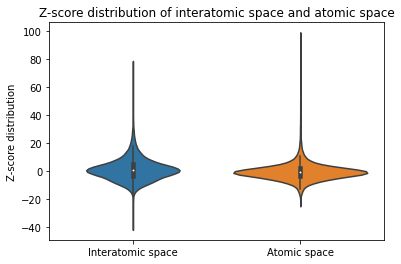

In [45]:
zscore_interatomic_space = zscore_map[interatomic_space_mask]
zscore_atomic_space = zscore_map[sharp_map_mask]

sns.violinplot([zscore_interatomic_space, zscore_atomic_space], inner="box")
plt.xticks([0, 1], ["Interatomic space", "Atomic space"])
plt.ylabel("Z-score distribution")
plt.title("Z-score distribution of interatomic space and atomic space")



In [17]:
# normality test for the three intensity difference variables 
from scipy.stats import normaltest
from scipy.stats import shapiro
normalise = lambda x: (x - x.mean())/x.std()
model_free_normtest = normaltest(normalise(model_free_intensity_difference))
hybrid_normtest = normaltest(normalise(hybrid_intensity_difference))
model_based_normtest = normaltest(normalise(model_based_intensity_difference))
shapiro_model_free = shapiro(normalise(model_free_intensity_difference))
shapiro_hybrid = shapiro(normalise(hybrid_intensity_difference))
shapiro_model_based = shapiro(normalise(model_based_intensity_difference))

print("Model free normality test: ", model_free_normtest, "p value: ", model_free_normtest.pvalue)
print("Hybrid normality test: ", hybrid_normtest, "p value: ", hybrid_normtest.pvalue)
print("Model based normality test: ", model_based_normtest, "p value: ", model_based_normtest.pvalue)
print("Shapiro model free: ", shapiro_model_free, "p value: ", shapiro_model_free.pvalue)
print("Shapiro hybrid: ", shapiro_hybrid, "p value: ", shapiro_hybrid.pvalue)
print("Shapiro model based: ", shapiro_model_based, "p value: ", shapiro_model_based.pvalue)

Model free normality test:  NormaltestResult(statistic=32767.683520199527, pvalue=0.0) p value:  0.0
Hybrid normality test:  NormaltestResult(statistic=14743.567761432865, pvalue=0.0) p value:  0.0
Model based normality test:  NormaltestResult(statistic=22789.0891230229, pvalue=0.0) p value:  0.0
Shapiro model free:  ShapiroResult(statistic=0.9016816020011902, pvalue=0.0) p value:  0.0
Shapiro hybrid:  ShapiroResult(statistic=0.9738274812698364, pvalue=0.0) p value:  0.0
Shapiro model based:  ShapiroResult(statistic=0.9096032977104187, pvalue=0.0) p value:  0.0


/home/abharadwaj1/miniconda3/envs/locscale_dev/lib/python3.7/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
